In [1]:
#import cubehelix
from joblib import Parallel, delayed
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import os
import pandas as pd
import seaborn as sns

import msaf       # Develop branch
import mir_eval   # Uri's fork: https://github.com/urinieto/mir_eval
#from mir_eval.segment import tree
#import tree
from segment_tree import tree
import segment_tree
mir_eval.segment = segment_tree

# Beatuiful seaborn plots
sns.set(style="ticks")
%matplotlib inline

# Colorhelix config
#cx = cubehelix.cmap(reverse=True, start=0.2, rot=-0.4, minLight=0.0, maxLight=1.0)

# SALAMI Path
#SALAMI_path = "/home/uri/datasets/Segments/references/"

In [54]:
cx = sns.cubehelix_palette(reverse=False, start=0.2, rot=-0.4, dark=0.45, light=1.0, as_cmap=True)

In [105]:
def gen_synthetic_labels(bounds):
    labels = []
    [labels.append(np.random.random(len(level) - 1)) for level in bounds]
    return labels

def evaluate_flat(ref_times, est_times, w, trim=False):
    ref_times = np.asarray(ref_times).flatten()
    est_times = np.asarray(est_times).flatten()
    ref_inter = np.asarray(zip(ref_times[:], ref_times[1:]))
    est_inter = np.asarray(zip(est_times[:], est_times[1:]))
    p, r, f = mir_eval.segment.detection(ref_inter, est_inter, trim=trim, window=w)
    R2E, E2R = mir_eval.segment.deviation(ref_inter, est_inter, trim=trim)
    print "F: %.2f\t P: %.2f\t R: %.2f" % (f * 100, p * 100, r * 100)
    print "R2E: %.2f\t E2R: %.2f" % (R2E, E2R)
    return f, p, r

def evaluate_hier(bounds1, bounds2, levels1=None, levels2=None, title=None, figsize=(7,3), 
                  ratios=[1,1], transitive=False, plot=True):
    labels1 = gen_synthetic_labels(bounds1)
    labels2 = gen_synthetic_labels(bounds2)
    tree1 = tree.SegmentTree(bounds1, labels1, levels1)
    tree2 = tree.SegmentTree(bounds2, labels2, levels2)
    res = 0.1
    for ws in [0.5, 3.0, 15, 30, None]:
        if ws is None:
            w = None
        else:
            w = int(ws / res)
        T_o, T_u, T_f = mir_eval.segment.hmeasure(tree1, tree2, transitive=transitive, window=w, res=res)
        if ws is None:
            ws = np.inf
        print "w: %.1f\t Tu: %.2f\t To: %.2f" % (ws, T_u * 100, T_o * 100)
    if plot:
        plt.figure(figsize=figsize)
        gs = gridspec.GridSpec(2, 1, height_ratios=ratios) 
        plt.subplot(gs[0])
        msaf.plotting.plot_tree(tree1, title="Reference", res=None, cmap_id=cx)
        plt.xlabel('')
        plt.subplot(gs[1])
        msaf.plotting.plot_tree(tree2, title="Estimation", res=None, cmap_id=cx)
        plt.tight_layout()

def remove_level(bounds, levels, level_id):
    for i, level in enumerate(levels):
        if level_id == level:
            bounds.pop(i)
            levels.pop(i)
            break

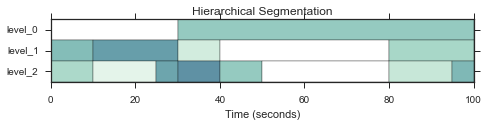

In [56]:
# Synthetic example
est_bounds = [[0, 30, 100], [0, 10, 30, 40, 80, 100], [0, 10, 25, 30, 40, 50, 80, 95, 100]]
est_labels = gen_synthetic_labels(est_bounds)
est_tree = tree.SegmentTree(est_bounds, est_labels)
plt.figure(figsize=(7,2))
msaf.plotting.plot_tree(est_tree, title="Hierarchical Segmentation", res=None, cmap_id=cx)
plt.tight_layout()
#plt.savefig("../figs/hier-example.pdf")

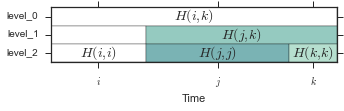

In [118]:
# Synthetic example (2)
orig_size = matplotlib.rcParams["font.size"]
matplotlib.rcParams["font.size"] = 14.
est_bounds = [[0, 30], [0, 10, 30], [0, 10, 25, 30]]
est_labels = gen_synthetic_labels(est_bounds)
est_tree = tree.SegmentTree(est_bounds, est_labels)
plt.figure(figsize=(5,1.75))
msaf.plotting.plot_tree(est_tree, 
                        #title="Hierarchical Segmentation", 
                        res=None,
                        cmap_id=cx)
plt.xticks([5, 17.5, 27.5], ["$i$", "$j$", "$k$"])
plt.tight_layout()
plt.xlabel("Time")

# Annotate level 2
plt.gca().text(5, 0.165, '$H(i,i)$', horizontalalignment='center', verticalalignment='center')
plt.gca().text(17.5, 0.165, '$H(j,j)$', horizontalalignment='center', verticalalignment='center')
plt.gca().text(27.5, 0.165, '$H(k,k)$', horizontalalignment='center', verticalalignment='center')
#plt.gca().text(35, 0.165, '$H(m,m)$', horizontalalignment='center', verticalalignment='center')

# Annotate level 1
plt.gca().text(20, 0.5, '$H(j,k)$', horizontalalignment='center', verticalalignment='center')

# Annotate level 0
plt.gca().text(15, .845, '$H(i,k)$', horizontalalignment='center', verticalalignment='center')

plt.savefig("../figs/hier-example.pdf", bbox_inches='tight', pad_inches=0.01)
matplotlib.rcParams["font.size"] = orig_size

F: 57.14	 P: 100.00	 R: 40.00
R2E: 10.00	 E2R: 0.00
Reduced
w: 0.5	 Tu: 40.00	 To: 100.00
w: 3.0	 Tu: 40.00	 To: 100.00
w: 15.0	 Tu: 39.39	 To: 52.77
w: 30.0	 Tu: 69.46	 To: 49.75
w: inf	 Tu: 80.00	 To: 49.75
Full
w: 0.5	 Tu: 40.00	 To: 100.00
w: 3.0	 Tu: 40.00	 To: 100.00
w: 15.0	 Tu: 39.39	 To: 52.77
w: 30.0	 Tu: 69.46	 To: 49.75
w: inf	 Tu: 80.00	 To: 49.75


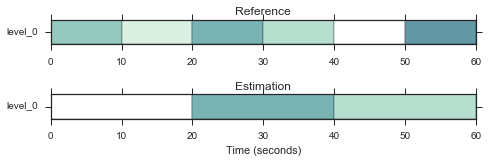

In [107]:
# Flat vs flat
f1 = [[0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 20, 40, 60]]
f, p, r = evaluate_flat(f1, f2, 3, trim=True)
print 'Reduced'
evaluate_hier(f1, f2, title="Flat vs Flat", figsize=(7,2.5), transitive=False)
print 'Full'
evaluate_hier(f1, f2, title="Flat vs Flat", figsize=(7,2.5), transitive=True, plot=False)
plt.savefig("../figs/flat-flat.pdf")

Reduced
w: 0.5	 Tu: 0.00	 To: 100.00
w: 3.0	 Tu: 0.00	 To: 100.00
w: 15.0	 Tu: 37.21	 To: 100.00
w: 30.0	 Tu: 69.66	 To: 100.00
w: inf	 Tu: 80.16	 To: 100.00
Full
w: 0.5	 Tu: 40.00	 To: 100.00
w: 3.0	 Tu: 40.00	 To: 100.00
w: 15.0	 Tu: 51.01	 To: 100.00
w: 30.0	 Tu: 81.76	 To: 100.00
w: inf	 Tu: 88.94	 To: 100.00


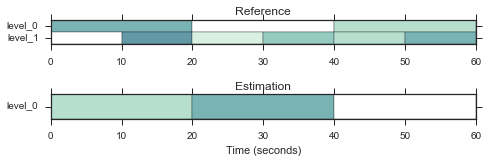

In [108]:
#Hierarchical vs Flat Large Scale
h1 = [[0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 20, 40, 60]]
print 'Reduced'
evaluate_hier(h1, f2, title="Hierarchical vs Flat Large Scale", figsize=(7,2.5), transitive=False)
print 'Full'
evaluate_hier(h1, f2, title="Hierarchical vs Flat Large Scale", figsize=(7,2.5), transitive=True, plot=False)
plt.savefig("../figs/hier-flatlarge.pdf")

Reduced
w: 0.5	 Tu: 66.67	 To: 100.00
w: 3.0	 Tu: 66.67	 To: 100.00
w: 15.0	 Tu: 48.90	 To: 73.03
w: 30.0	 Tu: 34.00	 To: 59.48
w: inf	 Tu: 26.59	 To: 58.23
Full
w: 0.5	 Tu: 40.00	 To: 100.00
w: 3.0	 Tu: 40.00	 To: 100.00
w: 15.0	 Tu: 44.16	 To: 73.03
w: 30.0	 Tu: 38.83	 To: 59.48
w: inf	 Tu: 40.63	 To: 58.23


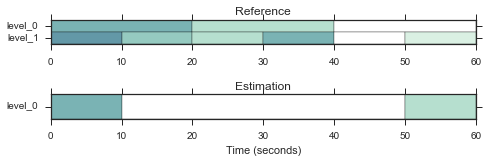

In [116]:
#Hierarchical vs Flat Large Scale
h1 = [[0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 10, 50, 60]]
print 'Reduced'
evaluate_hier(h1, f2, title="Hierarchical vs Flat Large Scale", figsize=(7,2.5), transitive=False)
print 'Full'
evaluate_hier(h1, f2, title="Hierarchical vs Flat Large Scale", figsize=(7,2.5), transitive=True, plot=False)
#plt.savefig("../figs/hier-flatlarge.pdf")

Reduced
w: 0.5	 Tu: 0.00	 To: 100.00
w: 3.0	 Tu: 0.00	 To: 100.00
w: 15.0	 Tu: 18.60	 To: 93.71
w: 30.0	 Tu: 37.10	 To: 71.46
w: inf	 Tu: 53.44	 To: 66.58
Full
w: 0.5	 Tu: 20.00	 To: 100.00
w: 3.0	 Tu: 20.00	 To: 100.00
w: 15.0	 Tu: 25.51	 To: 93.71
w: 30.0	 Tu: 43.50	 To: 71.46
w: inf	 Tu: 59.29	 To: 66.58


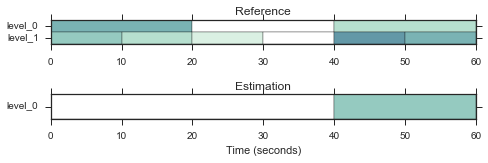

In [119]:
#Hierarchical vs Flat Larger Scale
h1 = [[0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 40, 60]]
print 'Reduced'
evaluate_hier(h1, f2, title="Hierarchical vs Flat Large Scale", figsize=(7,2.5), transitive=False)
print 'Full'
evaluate_hier(h1, f2, title="Hierarchical vs Flat Large Scale", figsize=(7,2.5), transitive=True, plot=False)
plt.tight_layout()
plt.savefig("../figs/hier-flatlarger.pdf")

Reduced
w: 0.5	 Tu: 100.00	 To: 100.00
w: 3.0	 Tu: 100.00	 To: 100.00
w: 15.0	 Tu: 62.79	 To: 100.00
w: 30.0	 Tu: 30.34	 To: 100.00
w: inf	 Tu: 19.84	 To: 100.00
Full
w: 0.5	 Tu: 100.00	 To: 100.00
w: 3.0	 Tu: 100.00	 To: 100.00
w: 15.0	 Tu: 76.31	 To: 100.00
w: 30.0	 Tu: 58.91	 To: 100.00
w: inf	 Tu: 55.31	 To: 100.00


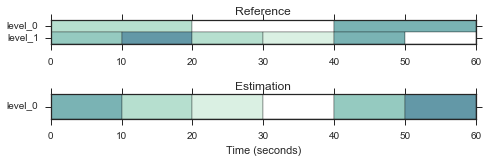

In [110]:
# Hierarchical vs Flat Small Scale
h1 = [[0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 10, 20, 30, 40, 50, 60]]
print 'Reduced'
evaluate_hier(h1, f2, title="Hierarchical vs Flat Small Scale", figsize=(7,2.5), transitive=False)
print 'Full'
evaluate_hier(h1, f2, title="Hierarchical vs Flat Small Scale", figsize=(7,2.5), transitive=True, plot=False)
plt.savefig("../figs/hier-flatsmall.pdf")

Reduced
w: 0.5	 Tu: 100.00	 To: 55.56
w: 3.0	 Tu: 98.16	 To: 56.43
w: 15.0	 Tu: 46.31	 To: 86.28
w: 30.0	 Tu: 21.80	 To: 92.47
w: inf	 Tu: 13.16	 To: 93.94
Full
w: 0.5	 Tu: 100.00	 To: 55.56
w: 3.0	 Tu: 97.79	 To: 56.43
w: 15.0	 Tu: 53.30	 To: 86.28
w: 30.0	 Tu: 39.69	 To: 92.47
w: inf	 Tu: 36.69	 To: 93.94


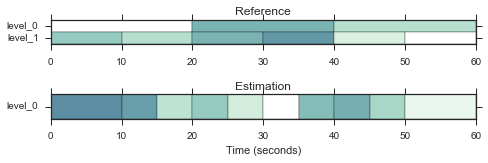

In [111]:
# Hierarchical vs Flat Smaller Scale
h1 = [[0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60]]
print 'Reduced'
evaluate_hier(h1, f2, title="Hierarchical vs Flat Small Scale", figsize=(7,2.5), transitive=False)
print 'Full'
evaluate_hier(h1, f2, title="Hierarchical vs Flat Small Scale", figsize=(7,2.5), plot=False, transitive=True)
plt.savefig("../figs/hier-flatsmaller.pdf")

Reduced
w: 0.5	 Tu: 100.00	 To: 100.00
w: 3.0	 Tu: 100.00	 To: 100.00
w: 15.0	 Tu: 100.00	 To: 98.32
w: 30.0	 Tu: 100.00	 To: 78.81
w: inf	 Tu: 100.00	 To: 61.85
Full
w: 0.5	 Tu: 100.00	 To: 100.00
w: 3.0	 Tu: 100.00	 To: 100.00
w: 15.0	 Tu: 100.00	 To: 99.13
w: 30.0	 Tu: 100.00	 To: 88.75
w: inf	 Tu: 100.00	 To: 79.41


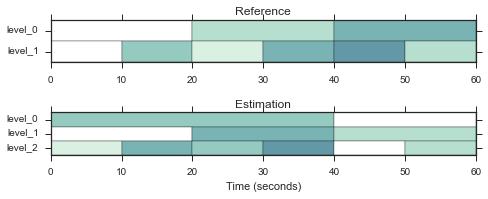

In [112]:
# Hierarchical vs Hierarchical
h1 = [[0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
h2 = [[0, 40, 60], [0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
print 'Reduced'
evaluate_hier(h1, h2, title="Hierarchical vs Hierarchical", figsize=(7,3), transitive=False)
print 'Full'
evaluate_hier(h1, h2, title="Hierarchical vs Hierarchical", figsize=(7,3), plot=False, transitive=True)
plt.savefig("../figs/hier-hiercomp.pdf")

In [91]:
reload(segment_tree)

<module 'segment_tree' from 'segment_tree.py'>

Reduced
w: 0.5	 Tu: 76.30	 To: 76.57
w: 3.0	 Tu: 95.03	 To: 94.57
w: 15.0	 Tu: 75.42	 To: 74.84
w: 30.0	 Tu: 61.76	 To: 82.64
w: inf	 Tu: 56.55	 To: 95.57
Full
w: 0.5	 Tu: 81.12	 To: 78.64
w: 3.0	 Tu: 96.08	 To: 93.02
w: 15.0	 Tu: 80.27	 To: 83.79
w: 30.0	 Tu: 70.53	 To: 89.01
w: inf	 Tu: 67.50	 To: 97.51


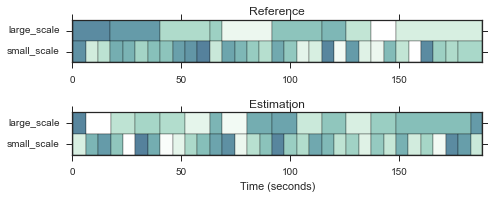

In [113]:
jams_file = "SALAMI_636.jams"
hier_bounds1, hier_labels1, hier_levels1 = msaf.io.read_hier_references('../test/' + jams_file, annotation_id=0)
hier_bounds2, hier_labels2, hier_levels2 = msaf.io.read_hier_references('../test/' + jams_file, annotation_id=1)

# Remove the function level
hier_levels1 = list(hier_levels1)
hier_levels2 = list(hier_levels2)
remove_level(hier_bounds1, hier_levels1, "function")
remove_level(hier_bounds2, hier_levels2, "function")

# Evaluate
print 'Reduced'
evaluate_hier(hier_bounds1, hier_bounds2, hier_levels1, hier_levels2, title="SALAMI vs SALAMI", figsize=(7,3), transitive=False)
print 'Full'
evaluate_hier(hier_bounds1, hier_bounds2, hier_levels1, hier_levels2, title="SALAMI vs SALAMI", figsize=(7,3), transitive=True, plot=False)
plt.savefig("../figs/SALAMI-SALAMI.pdf")

Reduced
w: 0.5	 Tu: 14.28	 To: 100.00
w: 3.0	 Tu: 19.85	 To: 99.91
w: 15.0	 Tu: 61.63	 To: 56.13
w: 30.0	 Tu: 76.14	 To: 53.12
w: inf	 Tu: 90.29	 To: 16.39
Full
w: 0.5	 Tu: 27.72	 To: 54.54
w: 3.0	 Tu: 33.97	 To: 71.80
w: 15.0	 Tu: 66.25	 To: 70.21
w: 30.0	 Tu: 79.87	 To: 58.09
w: inf	 Tu: 92.73	 To: 41.99


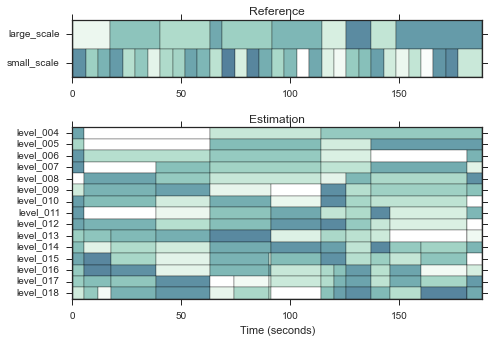

In [114]:
jams_file = "SALAMI_636.jams"
olda_file = "SALAMI_636_OLDA.jams"
hier_bounds1, hier_labels1, hier_levels1 = msaf.io.read_hier_references('../test/' +  jams_file)
hier_bounds2, hier_labels2, hier_levels2 = msaf.io.read_hier_references('../test/' + olda_file)

# Remove the function level from SALAMI
hier_levels1 = list(hier_levels1)
remove_level(hier_bounds1, hier_levels1, "function")

# Evaluate
print 'Reduced'
evaluate_hier(hier_bounds1, hier_bounds2, hier_levels1, hier_levels2, title="SALAMI vs OLDA", figsize=(7,5), ratios=[1,3],
             transitive=False)
print 'Full'
evaluate_hier(hier_bounds1, hier_bounds2, hier_levels1, hier_levels2, title="SALAMI vs OLDA", figsize=(7,5), ratios=[1,3],
             transitive=True, plot=False)
plt.savefig("../figs/SALAMI-OLDA.pdf")

In [ ]:
# Automatically set w
def analyze_salami(salami_file, windows):
    # Read annotations
    try:
        bounds1, labels1, levels1 = msaf.io.read_hier_references(salami_file.ref_file, annotation_id=0)
        bounds2, labels2, levels2 = msaf.io.read_hier_references(salami_file.ref_file, annotation_id=1)

        # Convert to tree
        labels1 = gen_synthetic_labels(bounds1)
        labels2 = gen_synthetic_labels(bounds2)
        tree1 = tree.SegmentTree(bounds1, labels1, levels1)
        tree2 = tree.SegmentTree(bounds2, labels2, levels2)

        # Evaluate
        print "Evaluating %s..." % salami_file.ref_file
        res = 0.1
        results = {}
        results["file"] = os.path.basename(salami_file.ref_file)
        for ws in windows:
            if ws is None:
                w = None
            else:
                w = int(ws / res)
            T_o, T_u, T_f = mir_eval.segment.hmeasure(tree1, tree2, transitive=True, window=w, res=res)
            if ws is None:
                ws = np.inf
            results["Tf_" + str(ws)] = T_f
            results["To_" + str(ws)] = T_o
            results["Tu_" + str(ws)] = T_u
    except:
        return []
    
    return results

n_jobs = 8
salami_files = msaf.io.get_dataset_files("/home/uri/datasets/Segments/", ds_name="SALAMI")
windows = [0.5, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

# Run in parallel
raw_results = Parallel(n_jobs=n_jobs)(delayed(analyze_salami)(salami_file, windows) 
                                      for salami_file in salami_files[:])

# Aggregate results in pandas format
results = pd.DataFrame()
for r in raw_results:
    if r != []:
        results = results.append(r, ignore_index=True)

In [205]:
print len(results)
print len(salami_files)
print results.mean()
print results.mean().values
print results.mean().keys()

411
769
Tf_0.5    0.486640
Tf_10     0.759037
Tf_15     0.774423
Tf_20     0.779053
Tf_25     0.780000
Tf_3      0.680829
Tf_30     0.779803
Tf_35     0.779188
Tf_40     0.778604
Tf_45     0.778144
Tf_5      0.717872
Tf_50     0.777820
Tf_55     0.777534
Tf_60     0.777178
To_0.5    0.499783
To_10     0.769224
To_15     0.781245
To_20     0.784930
To_25     0.786159
To_3      0.702033
To_30     0.786876
To_35     0.787605
To_40     0.788528
To_45     0.789533
To_5      0.735033
To_50     0.790664
To_55     0.791844
To_60     0.792967
Tu_0.5    0.520520
Tu_10     0.765296
Tu_15     0.780431
Tu_20     0.785594
Tu_25     0.786465
Tu_3      0.716995
Tu_30     0.785849
Tu_35     0.784651
Tu_40     0.783508
Tu_45     0.782631
Tu_5      0.738901
Tu_50     0.782004
Tu_55     0.781489
Tu_60     0.780940
dtype: float64
[ 0.48664029  0.75903677  0.77442256  0.77905268  0.78000027  0.68082947
  0.77980264  0.77918792  0.77860375  0.77814435  0.71787202  0.77781964
  0.77753406  0.77717769  0.49978

In [206]:
results.to_csv("searching_w.csv")

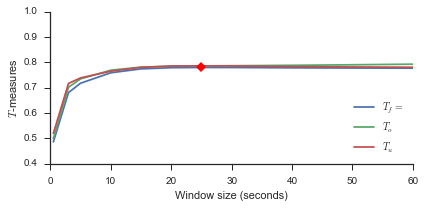

In [229]:
plt.figure(figsize=(6,3))
Tf_keys = ["Tf_" + str(w) for w in windows]
To_keys = ["To_" + str(w) for w in windows]
Tu_keys = ["Tu_" + str(w) for w in windows]
plt.plot(windows, results[Tf_keys].mean().values, label="$T_f = \frac{2T_u T_o}{T_u + T_o}$")
plt.plot(windows, results[To_keys].mean().values, label="$T_o$")
plt.plot(windows, results[Tu_keys].mean().values, label="$T_u$")
plt.plot(windows[np.argmax(results[Tf_keys].mean().values)], 
         np.max(results[Tf_keys].mean().values), 'rD')
plt.ylim((0.4,1))
plt.legend(loc='lower right')
plt.xlabel("Window size (seconds)")
plt.ylabel("$T$-measures")
sns.despine()
plt.tight_layout()
plt.savefig("../figs/exploring_w.pdf")